In [1]:
import tqdm
import torch.nn as nn
import torch
from torch.optim import SGD
from torch.optim import RMSprop
from torch.optim import Adam
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tensorboard
from torch.autograd import Variable  
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import chi2
import pandas as pd
import datetime

In [2]:
#1時間ごとでの
with open('BTC-2021min.csv') as f:
    reader = csv.reader(f)
    l = [row for row in reader]
    minuites_data = [float(l[i][3]) for i in range(2, len(l))]
    m_data = np.array(minuites_data)

In [3]:
def log_delta(data):
    data = np.log(data)
    data = data[1:-1] - data[0:-2]
    return data

In [4]:
m_data = log_delta(m_data)

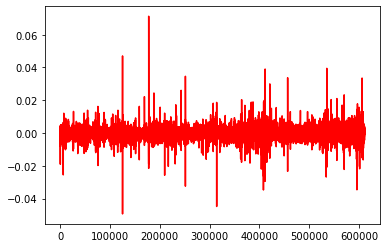

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(m_data, color = "r")

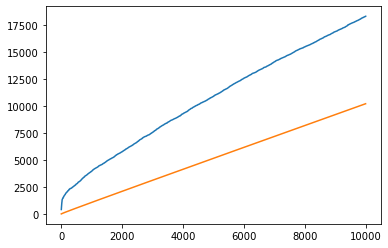

In [6]:
#かばん検定
# lags = 10000

# result = acorr_ljungbox(m_data ,lags = lags)
# c2 = chi2.ppf(0.95, df=np.arange(1,lags))

# plt.plot(result['lb_stat'])
# plt.plot(c2)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [8]:
rate = 0.95
expect_len = 100
coef_arr = np.array([rate ** i for i in range(expect_len)])

def value_s(np_array):
    vs = np.sum((np_array - np_array[0]) * coef_arr[0:len(np_array)])
    return vs

def mkDataSet(data_size, data_length, validation_size):
    train_x = np.empty((data_size, data_length, 1))
    train_t = np.empty((data_size, 1))
    valid_x = np.empty((validation_size, data_length, 1))
    valid_t = np.empty((validation_size, 1))
    
    for offset in tqdm.tqdm(range(data_size)):
        train_x[offset] = m_data[offset:offset + data_length].reshape(data_length, 1)
        train_t[offset] = [value_s(m_data[offset + data_length:offset + data_length + expect_len])]
        
    for offset in tqdm.tqdm(range(validation_size)):
        valid_x[offset] = m_data[offset + data_size:offset + data_size + data_length].reshape(data_length, 1)
        valid_t[offset] = [value_s(m_data[offset + data_size + data_length:offset + data_size + data_length + expect_len])]
        
    return train_x, train_t, valid_x, valid_t

def mkBatchSet(train_x, train_t, batch_size):
    batch_x = []
    batch_t = []    
    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x)-1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
        
    batch_x = np.array(batch_x).astype(np.float32)
    batch_t = np.array(batch_t).astype(np.float32)

    return torch.from_numpy(batch_x).clone().reshape(batch_size, 1, -1).to(device), torch.from_numpy(batch_t).clone().to(device)

In [9]:
data_length = 10000
validation_size = 200000
training_size = len(m_data) - data_length - validation_size - expect_len
hidden_size = 10
batch_size = 32

train_x, train_t, valid_x, valid_t = mkDataSet(training_size, data_length, validation_size)
data, label = mkBatchSet(train_x, train_t, batch_size)

100% 400679/400679 [00:08<00:00, 46884.67it/s]
100% 200000/200000 [00:04<00:00, 46410.60it/s]


In [10]:
class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()
        self.hiddenDim = hiddenDim
        self.kernel_size1 = 5000
        self.kernel_size2 = 2500
        self.kernel_size3 = 500
        self.kernel_size4 = 250
        self.kernel_size5 = 100
        self.kernel_size6 = 50
        self.seq_len = ((inputDim - self.kernel_size1 + 1 - self.kernel_size2 + 1) // 2 - self.kernel_size3 + 1 - self.kernel_size4 + 1) // 2 - self.kernel_size5 + 1 - self.kernel_size6 + 1
        
        self.conv1d_1 = nn.Conv1d(1, 16, self.kernel_size1)
        self.conv1d_2 = nn.Conv1d(16, 32, self.kernel_size2)
        self.maxpool1 = nn.MaxPool1d(2)
        self.conv1d_3 = nn.Conv1d(32, 64, self.kernel_size3)
        self.conv1d_4 = nn.Conv1d(64, 64, self.kernel_size4)
        self.maxpool2 = nn.MaxPool1d(2)
        self.conv1d_5 = nn.Conv1d(64, 64, self.kernel_size5)
        self.conv1d_6 = nn.Conv1d(64, 64, self.kernel_size6)
        self.rnn1 = nn.LSTM(input_size=64, hidden_size=hiddenDim, batch_first=True) #batch_first=Trueで(seq, batch, vec)->(batch, seq, vec)に入力の形を変更
        self.rnn2 = nn.LSTM(input_size=hiddenDim, hidden_size=hiddenDim, batch_first=True) #batch_first=Trueで(seq, batch, vec)->(batch, seq, vec)に入力の形を変更
        self.output_layer = nn.Linear(hiddenDim, outputDim)

    def forward(self, input):
        output = self.conv1d_1(input)
        output = self.conv1d_2(output)
        output = self.maxpool1(output)
        output = self.conv1d_3(output)
        output = self.conv1d_4(output)
        output = self.maxpool2(output)
        output = self.conv1d_5(output)
        output = self.conv1d_6(output)
        h_0_1 = None
        output = output.reshape(-1, self.seq_len, 64)
        output, (hidden, cell) = self.rnn1(output, (h_0_1)) #LSTMのforwardのreturnはこのような戻り値になっている
        h_0_2 = None
        output, (hidden, cell) = self.rnn2(output, (h_0_2))
        output = self.output_layer(output[:, -1, :]) #LSTMのoutput=(batch, seq, hidden)からseqのみ最後のやつだけを取り出す
        return output

In [11]:
model = Predictor(data_length, hidden_size, 1).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [12]:
loss_history = []
epoch_num = 100000
for epoch in tqdm.tqdm(range(epoch_num)):
    optimizer.zero_grad()
    data, label = mkBatchSet(train_x, train_t, batch_size)
    output = model(data)

    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    running_loss = torch.sum(loss.data)
    loss_history.append(running_loss.to('cpu').detach().numpy().copy())
    
    if (epoch+1) % 1000 == 0:
        print('%d loss: %3f' % (epoch+1, running_loss))

  1% 1000/100000 [03:57<6:30:04,  4.23it/s]

1000 loss: 0.000828


  2% 2000/100000 [07:55<6:26:26,  4.23it/s]

2000 loss: 0.000449


  3% 3000/100000 [12:00<7:00:20,  3.85it/s]

3000 loss: 0.000456


  4% 4000/100000 [16:16<6:28:15,  4.12it/s]

4000 loss: 0.000407


  5% 5000/100000 [20:13<6:15:08,  4.22it/s]

5000 loss: 0.000305


  6% 6000/100000 [24:04<6:10:15,  4.23it/s]

6000 loss: 0.000503


  7% 7000/100000 [27:56<6:05:47,  4.24it/s]

7000 loss: 0.000246


  8% 8000/100000 [31:48<5:44:58,  4.44it/s]

8000 loss: 0.000213


  9% 9000/100000 [35:39<5:58:21,  4.23it/s]

9000 loss: 0.001160


 10% 10000/100000 [39:31<5:36:29,  4.46it/s]

10000 loss: 0.000398


 10% 10129/100000 [40:01<5:55:11,  4.22it/s]


KeyboardInterrupt: 

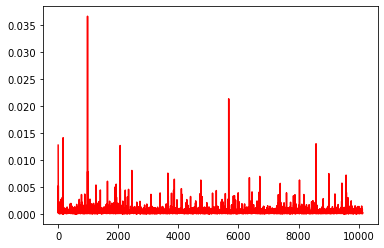

In [13]:
loss_history = np.array(loss_history)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loss_history, color = "r")

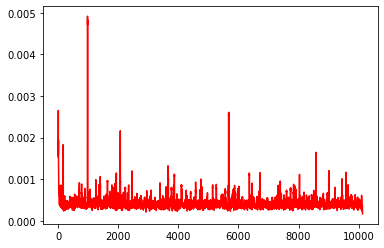

In [14]:
window = 10 # 移動平均の範囲
w = np.ones(window)/window

loss_hist_convolve = np.convolve(loss_history, w, mode='same')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(loss_hist_convolve, color = "r")

In [15]:
state = 0 #0->1で買い　1->0で売り
reward = 0.
last_output = 0.
buy_chart = 0.
output_vs = []
with torch.no_grad():
    for test_data in tqdm.tqdm(train_x):
        output = model(torch.from_numpy(test_data.astype(np.float32)).clone().reshape(1, 1, -1).to(device))
        if output.data > last_output:
            if state == 0:
                reward += test_data[-1][0] - buy_chart
            state = 1
        else:
            if state == 1:
                buy_chart = test_data[-1][0]
            state = 0
        output_vs.append(np.squeeze(output.data.to('cpu').detach().numpy().copy()))
        last_output = output.data
        
print(reward)

 17% 67188/400679 [08:07<40:21, 137.71it/s]


KeyboardInterrupt: 

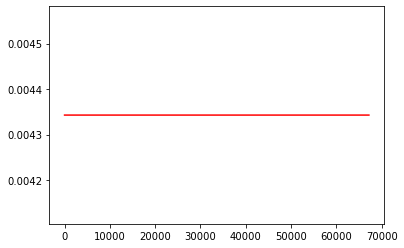

In [16]:
output_vs = np.array(output_vs)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(output_vs, color = "r")

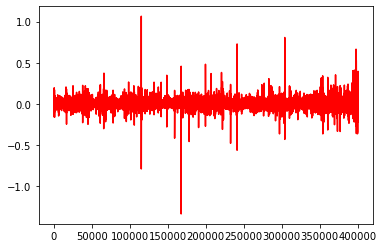

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.squeeze(train_t), color = "r")

In [18]:
state = 0 #0->1で買い　1->0で売り
reward = 0.
last_output = 0.
buy_chart = 0.
output_vs = []
with torch.no_grad():
    for test_data in tqdm.tqdm(valid_x):
        output = model(torch.from_numpy(test_data.astype(np.float32)).clone().reshape(1, 1, -1).to(device))
        if output.data > last_output:
            if state == 0:
                reward += test_data[-1][0] - buy_chart
            state = 1
        else:
            if state == 1:
                buy_chart = test_data[-1][0]
            state = 0
        output_vs.append(np.squeeze(output.data.to('cpu').detach().numpy().copy()))
        last_output = output.data
        
print(reward)

output_vs = np.array(output_vs)

  1% 1505/200000 [00:11<24:21, 135.85it/s]


KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(output_vs, color = "r")

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.squeeze(valid_t), color = "r")

In [ ]:
# def mkRandomBatch(train_x, train_t, batch_size=10):
#     batch_x = []
#     batch_t = []
    
#     for _ in range(batch_size):
#         idx = np.random.randint(0, len(train_x)-1)
#         batch_x.append(train_x[idx])
#         batch_t.append(train_t[idx])
    
#     return torch.tensor(batch_x), torch.tensor(batch_t)

In [ ]:
# batch_size = 10

# for epoch in range(epoch_num):
#     running_loss = 0.0
#     last_training_accuracy = 0.0
#     correct = 0.0
#     for i in range(int(training_size / batch_size)):
#         optimizer.zero_grad()
#         data, label = mkRandomBatch(train_x, train_t, batch_size)

#         output = model(data)

#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.data
#         correct += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)
    
#     training_accuracy = correct / training_size
#     print('%d loss: %3f, training_accuracy: %.5f' % (epoch+1, running_loss, training_accuracy))
#     if last_training_accuracy > training_accuracy:
#         break
#     last_training_accuracy = training_accuracy